# Notebook to compare modelled (MERRA-2, SNOWPACK, RACMO2, and MAR) vs observed SMB from IceBridge snow accumulation radar.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import xarray as xr
from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from calendar import monthrange
from scipy import stats

## Load observed SMB from Dattler et. al., 2019

In [44]:
obs_lat, obs_lon, obs_accumulation, relative_accumulation, relative_accumulation_error = \
    np.loadtxt("/pl/active/nasa_smb/Data/Accumulation_Data_Product.csv", skiprows=1, delimiter=',', unpack=True)

# Transform obs lat/lon into epsg 3031

In [45]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
obs_X = np.zeros(len(obs_lon)); obs_X[:] = np.nan
obs_Y = np.zeros(len(obs_lon)); obs_Y[:] = np.nan

# Perform transformation
for j in range(0, len(obs_X)):
    coords = transform.TransformPoint(obs_lat[j], obs_lon[j]) # Lat, Lon
    obs_X[j], obs_Y[j] = coords[0:2]

## Load SNOWPACK SMB

In [46]:
# SNOWPACK SMB
# path = "../../nc_storage/latest_wn_zero_flux_falseBC_false.nc"
path = "../output/grids/a3d_grids_1980.nc"
# path = "/scratch/summit/erke2265/spinup_2_output/grids/a3d_grids_1980.nc"
ds = xr.open_dataset(path)

# Trim grids
# ds = ds.isel(time=slice(0, 713)) # Jan
# ds = ds.isel(time=slice(-744, -1)) # Dec
# ds = ds.isel(time=slice(4367, 4367 + 31*24)) # July
# ds = ds.isel(time=slice(4367, 4367 + 31*24)) # July
# ds = ds.isel(time=slice(2903, 2903 + 31*24)) # May
# ds = ds.isel(time=slice(1440, 1440 + 31*24)) # March

ds = ds.isel(easting=slice(15, -15))
ds = ds.isel(northing=slice(15, -15))
# ds = ds.isel(time=slice(0, 470))
ds
# # SNOWPACK topography 
# dem = np.flipud(np.loadtxt("../input/surface-grids/dem.asc", skiprows=6))
# dem = xr.DataArray(dem, coords=[ds['northing'], ds['easting']], dims=['northing', 'easting'])

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 470)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T01:00:00 ... 1980-01-20T14:00:00
  * northing               (northing) float32 -108500.0 -107500.0 ... -2500.0
  * easting                (easting) float32 -1542500.0 ... -1375500.0
Data variables:
    dw                     (time, northing, easting) float32 ...
    ERODEDMASS             (time, northing, easting) float32 ...
    ET                     (time, northing, easting) float32 ...
    snd                    (time, northing, easting) float32 ...
    rlds                   (time, northing, easting) float32 ...
    rsds                   (time, northing, easting) float32 ...
    MS_HNW                 (time, northing, easting) float32 ...
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 ...
    MS_WIND                (time, northing, easting) float32 ...
    pr                     (time, northing, easting) float32 ...
    hur                    (time, northing, easting) float32 ...
    RHO1                   (time, northing, easting) float32 ...
    RHO2                   (time, northing, easting) float32 ...
    RHO3                   (time, northing, easting) float32 ...
    RHO4                   (time, northing, easting) float32 ...
    RHO5                   (time, northing, easting) float32 ...
    SFC_SUBL               (time, northing, easting) float32 ...
    SURF_ALB               (time, northing, easting) float32 ...
    swe                    (time, northing, easting) float32 ...
    ta                     (time, northing, easting) float32 ...
    ts                     (time, northing, easting) float32 ...
    ws                     (time, northing, easting) float32 ...
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 ...
Attributes:
    date_created:              2021-10-22
    creator_name:              erke2265
    source:                    MeteoIO-3.00
    history:                   2021-10-22T20:20:54Z, erke2265@shas0116.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1557500.0000000000 -123500.00000000...

## Determine SNOWPACK domain corners

In [47]:
domain_left = ds['easting'].min()
domain_right = ds['easting'].max()
domain_bottom = ds['northing'].min()
domain_top = ds['northing'].max()

## Plot observed SMB (blue circles) and model domain (red rectangle)

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


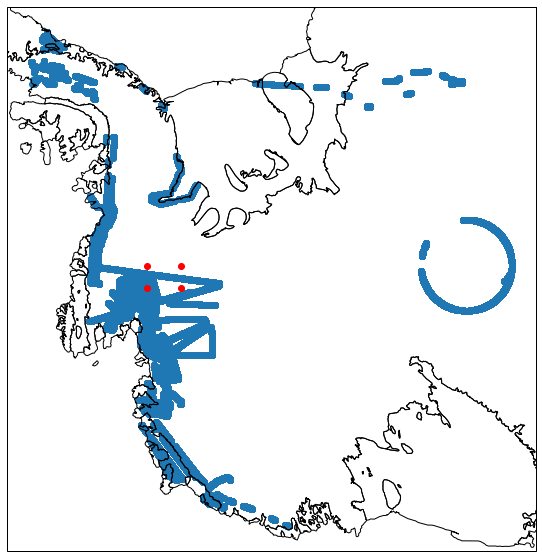

In [48]:
# Coastline Data
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Map
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
# axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree()) # Entire ice sheet
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot obs locations
space = 1
plt.scatter(obs_X[::space], obs_Y[::space], linewidth=1)

# Plot model domain
plt.scatter(domain_left, domain_bottom, c='r')
plt.scatter(domain_left, domain_top, c='r')
plt.scatter(domain_right, domain_bottom, c='r')
plt.scatter(domain_right, domain_top, c='r')

## Determine indices of observations which are in SNOWPACK model domain

In [49]:
# Function to get indices of observations inside of the model domain
def get_domain_obs(obsX, obsY, obs_accum, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon):
    '''
    Find obs whose X and Y are:
        X: greater than domain_left and less than domain_right
        Y: greater than domain_bottom and less than domain_top
    ''' 
    filter_func = np.vectorize(lambda obsX, obsY: obsX <= domain_right and obsX >= domain_left and obsY >= domain_bottom and obsY <= domain_top)
    indices = filter_func(obsX, obsY)
    obs_accum_filter = obs_accum[indices]
    obsX_filter = obsX[indices]
    obsY_filter = obsY[indices]
    obs_lat_filter = obs_lat[indices]
    obs_lon_filter = obs_lon[indices]
    
    return obsX_filter, obsY_filter, obs_accum_filter, obs_lat_filter, obs_lon_filter

## Retrieve observed SMB 

In [50]:
# # Retrieve observations
obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, obs_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

# Relative observations
# obs_X, obs_Y, obs_accumulation, obs_lat, obs_lon = get_domain_obs(obs_X, obs_Y, relative_accumulation, domain_left, domain_right, domain_bottom, domain_top, obs_lat, obs_lon)

## Retrieve SNOWPACK SMB

In [51]:
tgt_x = xr.DataArray(obs_X, dims="points")
tgt_y = xr.DataArray(obs_Y, dims="points")

SNOWPACK_SMB = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
SNOWPACK_SMB = 1000 * SNOWPACK_SMB.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# # Use a different wind speed simulation
# ds_wind = xr.open_dataset("/scratch/summit/erke2265/LISTON_EXPLORE/output/grids/a3d_grids_1980.nc")
# ds_wind = ds_wind.isel(easting=slice(15, -15))
# ds_wind = ds_wind.isel(northing=slice(15, -15))
# SNOWPACK_ws = ds_wind['ws'].resample(time="1D").mean().mean(dim='time')
# SNOWPACK_ws = SNOWPACK_ws.sel(northing=tgt_y, easting=tgt_x, method='nearest')

SNOWPACK_ws = ds['ws'].resample(time="1D").mean().mean(dim='time')
SNOWPACK_ws = SNOWPACK_ws.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# SNOWPACK_we = ds['WINDEROSIONDEPOSITION'].sum(dim='time')
SNOWPACK_we = ds['WINDEROSIONDEPOSITION'].resample(time="1D").sum().sum(dim='time')
SNOWPACK_we = SNOWPACK_we.sel(northing=tgt_y, easting=tgt_x, method='nearest')

# # Retrieve elevation at observations
# dem_obs = dem.sel(northing=obs_Y, easting=obs_X, method='nearest')
# dem_obs = dem_obs.values.diagonal()

# Retrieve RACMO2 SMB

In [52]:
# import xarray as xr
# import pyproj
# from pyproj import Proj, transform
# from fiona.crs import from_epsg

# # Define source epsg and target projection. The later is obtained from ncdump. 
# src_epsg = 3031 # Antarctic Stereo
# tgt_proj = "-m 57.295779506 +proj=ob_tran +o_proj=latlon +o_lat_p=-167.0 +lon_0=53.0"

# # Convert array of lat/lon in source epsg to the rotated grid
# rlon_obs, rlat_obs = transform(Proj(from_epsg(src_epsg)), Proj(tgt_proj), obs_X, obs_Y)

# # Now retrieve RACMO2 data at grid cells closest to lat/lon array
# # R2 = xr.open_dataset("smb_avg.nc")
# R2 = xr.open_dataset("year_cum_smb_ASE055_1979-2015.nc")
# R2_SMB = R2['smb'].mean(dim='time')

# lat_indices = np.zeros(len(rlat_obs)); lat_indices[:] = np.nan
# lon_indices = np.zeros(len(rlat_obs)); lon_indices[:] = np.nan
# R2_obs = np.zeros(len(rlat_obs)); R2_obs[:] = np.nan

# for j in range(0, len(rlat_obs)):
#     lat_diff = np.abs(R2['rlat'] - rlat_obs[j])
#     lat_indices[j] = np.argmin(lat_diff)
#     lon_diff = np.abs(R2['rlon'] - rlon_obs[j])
#     lon_indices[j] = np.argmin(lon_diff)
#     R2_obs[j] = R2_SMB[0,int(lat_indices[j]), int(lon_indices[j])]

## Retrieve MERRA-2 SMB

In [53]:
# Calculate seconds in each month from 1980 - 2020
seconds = np.zeros(492); seconds[:] = np.nan
count = -1
for year in range(1980, 2020 + 1):
    for month in range(1, 12 + 1):
        count = count + 1
        tmp = monthrange(year, month)
        seconds[count] = float(tmp[1]) * 24 * 60 * 60

# Path
data_path = "/scratch/summit/erke2265/MERRA2_monthly/"

# Precipitation
sn = xr.open_mfdataset(data_path + "PRECSN_monthly_*.nc", concat_dim="time")
ls = xr.open_mfdataset(data_path + "PRECLS_monthly_*.nc", concat_dim="time")
cu = xr.open_mfdataset(data_path + "PRECCU_monthly_*.nc", concat_dim="time")

# Evaporation 
evap = xr.open_mfdataset(data_path + "EVAP_monthly_*.nc", concat_dim="time")

# SMB
M2_smb = sn['PRECSN'] + ls['PRECLS'] + cu['PRECCU'] - evap['EVAP']
M2_smb = M2_smb.mean(dim='time').mean(dim='month') * seconds.mean() * 12

# Now get MERRA-2 at the observaions locations
tgt_lon = xr.DataArray(obs_lon, dims="points")
tgt_lat = xr.DataArray(obs_lat, dims="points")
M2_obs = M2_smb.sel(lat=tgt_lat, lon=tgt_lon, method='nearest')
# M2_obs = M2_smb.sel(lat=obs_lat, lon=obs_lon, method='nearest')
# M2_obs = M2_obs.values.diagonal()

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,
/projects/erke2265/miniconda/

# Retrive Brooke's MERRA-2 Random Forest SMB Perturation

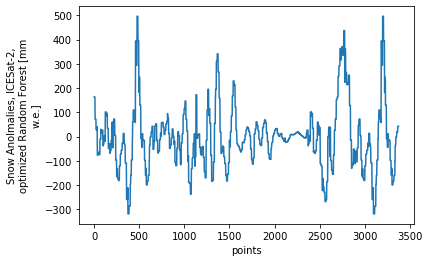

In [54]:
M2_RF = xr.open_dataset("/pl/active/nasa_smb/Data/RF_Snow_Red_prelim.nc")
M2_RF = M2_RF['IS2_opt']
M2_RF = M2_RF.sel(x=tgt_x, y=tgt_y, method='nearest')
M2_RF.plot()

## Retrieve MAR SMB

In [55]:
# MAR_path = "/pl/active/nasa_smb/MAR/MARv3.6.4-Antarctica/MERRA2/"
# MAR_smb = xr.open_dataset(MAR_path + "MAR-MERRA2_smb_1980-2015_annual.nc4")
# MAR_smb = MAR_smb['smb'].mean(dim='time')
# MAR_obs = MAR_smb[0,:,:].sel(x=obs_X/1000, y=obs_Y/1000, method='nearest')
# MAR_obs = MAR_obs.values.diagonal()

# Get other A3D simulations

In [56]:
# def get_a3d(path, x_trim, y_trim, obs_X, obs_Y):
#     # Open with xarray
#     ds = xr.open_dataset(path)
    
#     # Trim grids
#     ds = ds.isel(easting=slice(x_trim, -x_trim))
#     ds = ds.isel(northing=slice(y_trim, -y_trim))
    
#     # Get SMB
#     SNOWPACK_SMB = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
#     SNOWPACK_SMB = SNOWPACK_SMB.sel(northing=obs_Y, easting=obs_X, method='nearest')
#     SNOWPACK_SMB = SNOWPACK_SMB.values.diagonal()
#     SNOWPACK_SMB = SNOWPACK_SMB * 1000
    
#     # Return SMB
#     return SNOWPACK_SMB

# A3D_base = get_a3d("../../base.nc", 5, 5, obs_X, obs_Y)
# A3D_RL = get_a3d("../../RL.nc", 5, 5, obs_X, obs_Y)
# A3D_FL = get_a3d("../../FL.nc", 5, 5, obs_X, obs_Y)
# A3D_AV = get_a3d("../../AV.nc", 5, 5, obs_X, obs_Y)
# A3D_RL_FL = get_a3d("../../RL_FL.nc", 5, 5, obs_X, obs_Y)

# Plot all transects

In [57]:
delta_dat = np.sqrt(np.diff(obs_X)**2 + np.diff(obs_Y)**2)
big_diff = np.where(delta_dat > 2e3)

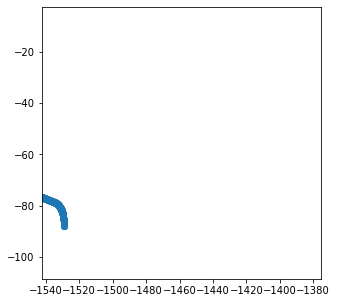

<Figure size 432x288 with 0 Axes>

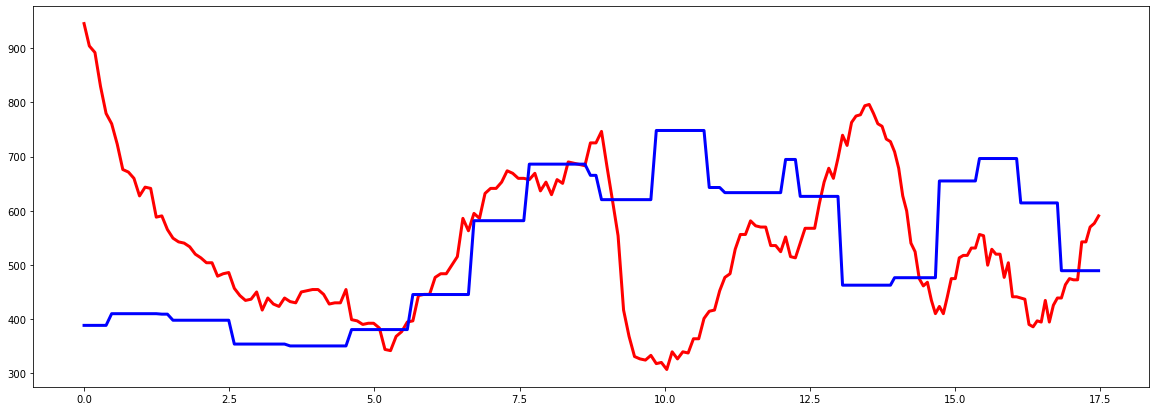

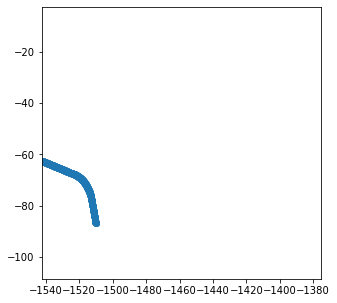

<Figure size 432x288 with 0 Axes>

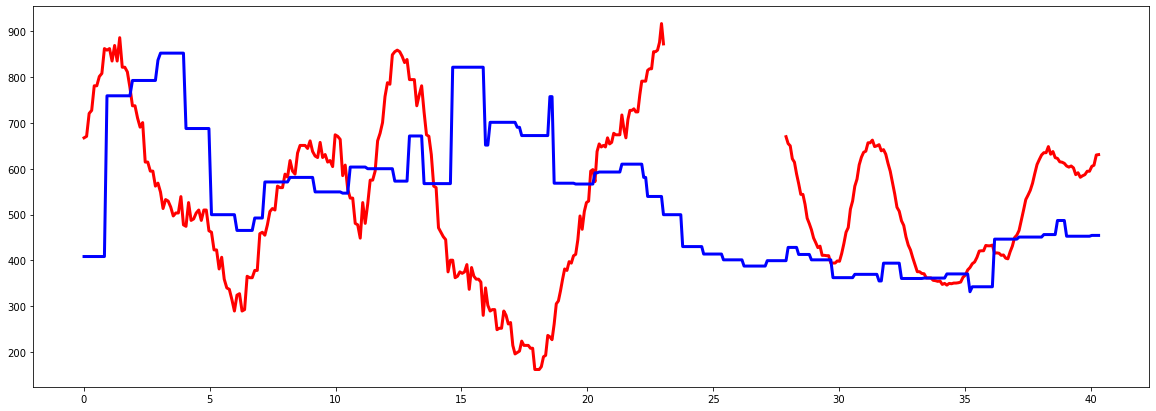

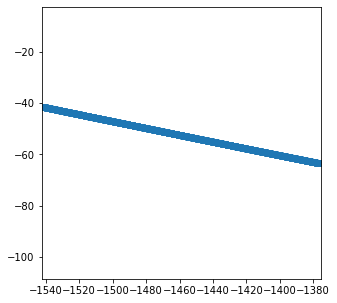

<Figure size 432x288 with 0 Axes>

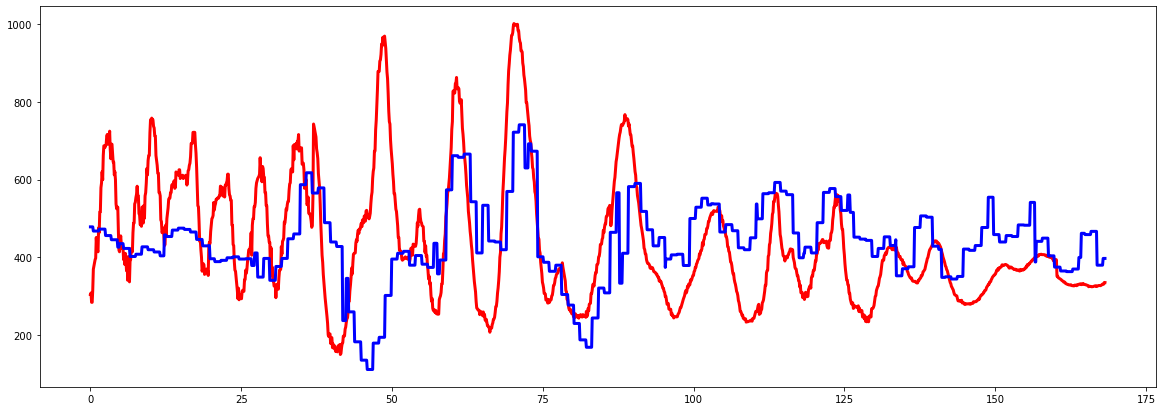

In [58]:
ind0 = 0
indf = big_diff[0][0]
indices = np.arange(ind0, indf)

for j in range(0, len(big_diff[0])-1):
# for j in range(0, 2):

    # Plot map
    plt.figure(figsize=(5,5))
    plt.scatter(obs_X[indices]/1000, obs_Y[indices]/1000)
    plt.xlim([domain_left/1000, domain_right/1000])
    plt.ylim([domain_bottom/1000, domain_top/1000])
    
    # Have the same mean as observations
    snowpack_factor = 1000 * np.nanmean(obs_accumulation[indices]) / SNOWPACK_SMB[indices].mean()
#     snowpack_factor = 1
    
    # Calculate distance along track (dat)
    dat = np.zeros(len(indices)); dat[:] = np.nan
    x0 = obs_X[ind0]; y0 = obs_Y[ind0]
    count = -1 # Add hock index counter 

    for jj in range(ind0, indf):
        count = count + 1
        dat[count] = np.sqrt(np.square(obs_X[jj] - x0) + np.square(obs_Y[jj] - y0)) / 1000
        
    # Plot A3D, and other models
    plt.figure()
    fig, ax1 = plt.subplots(figsize=(20,7))
    plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations (Long term mean): Dattler 2019', linewidth=3)
    plt.plot(dat, snowpack_factor*SNOWPACK_SMB[indices], 'b', label='Alpine-3D 1 km', linewidth=3)
#     plt.plot(dat, M2_obs[indices], 'c', label='MERRA-2 (1980 - 2020 mean)', linewidth=3)
    
    # Update indices
    ind0 = indf + 1
    indf = big_diff[0][j+1]
    indices = np.arange(ind0, indf)

## Horizontal ransect of SNOWPACK vs obserced SMB 

Mean Observations
    460.6147720202481

Mean Alpine-3D
    460.6147720202481
    Alpine-3D Factor = 113.4818509560943



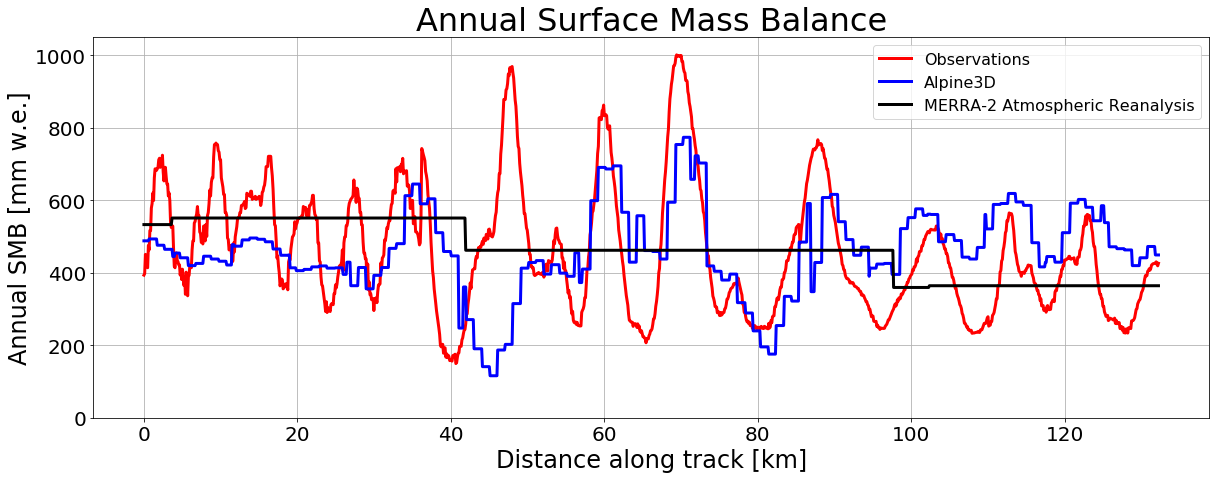

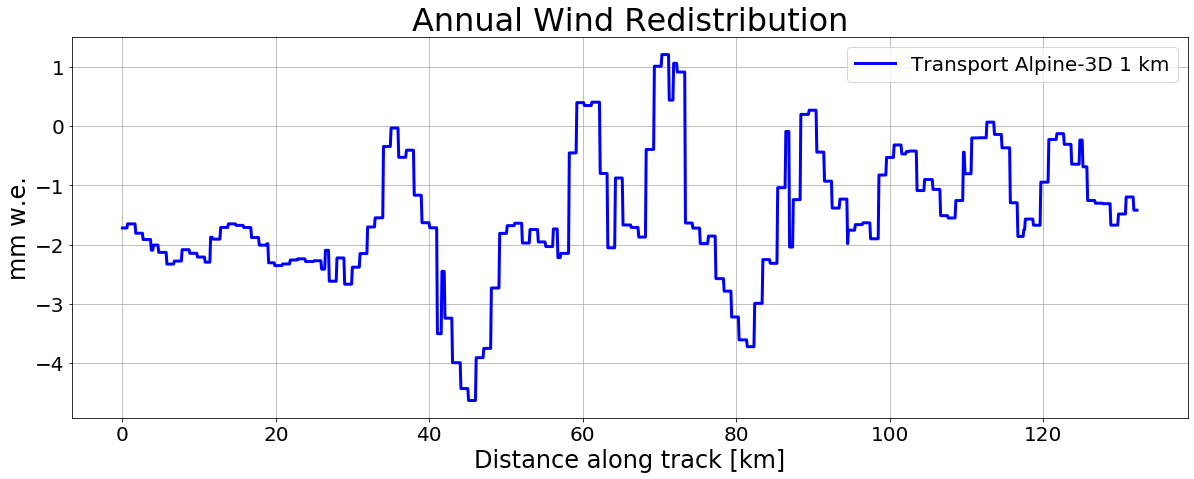

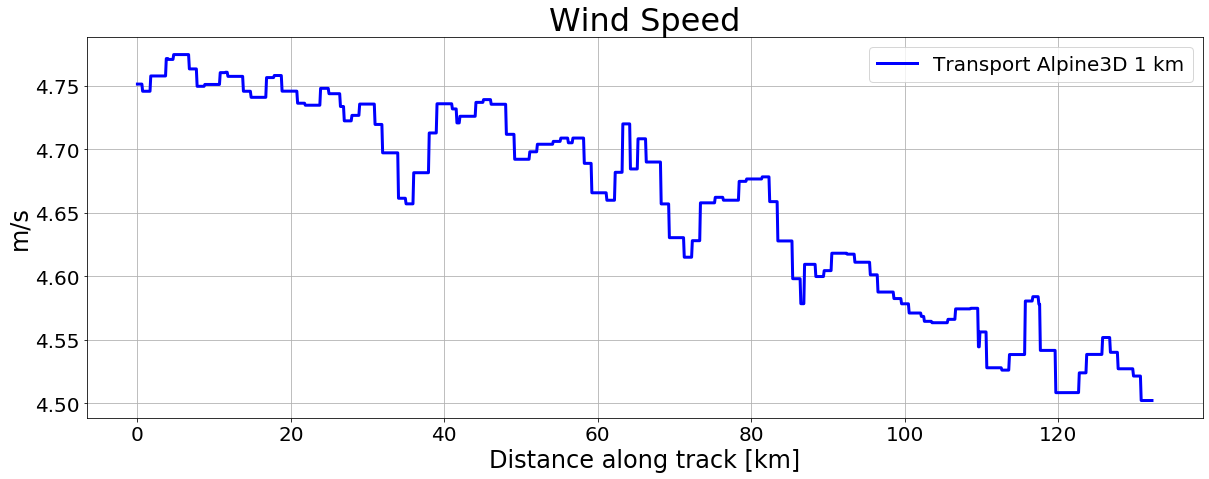

In [59]:
# Indices to plot
ind0 = 660 # I've typically done 1000:2000
indf = 2000
indices = np.arange(ind0, indf)

# Gradient of topography 
# topo_gradient = np.gradient(dem_obs[indices])

# Calculate SNOWPACK multiplicative factor
# By how many timesteps have run
# hy = 24*365 # Hours in a year
# snowpack_factor = hy / len(ds['time'])

# Have the same mean as observations
snowpack_factor = 1000 * obs_accumulation[indices].mean() / SNOWPACK_SMB[indices].mean()
M2_factor = 1000 * obs_accumulation[indices].mean() / M2_obs[indices].mean()
# R2_factor = 1000 * obs_accumulation[indices].mean() / R2_obs[indices].mean()
# MAR_factor = 1000 * obs_accumulation[indices].mean() / MAR_obs[indices].mean()
# gradient_factor = 1000 * obs_accumulation[indices].mean() / topo_gradient.mean()

# # Constant factor
# snowpack_factor = 1
M2_factor = 1
R2_factor = 1
MAR_factor = 1
gradient_factor = 1

# Calculate distance along track (dat)
dat = np.zeros(len(indices)); dat[:] = np.nan
x0 = obs_X[ind0]; y0 = obs_Y[ind0]
count = -1 # Add hock index counter 

for j in range(ind0, indf):
    count = count + 1
    dat[count] = np.sqrt(np.square(obs_X[j] - x0) + np.square(obs_Y[j] - y0)) / 1000
    
# # Save base transect
# snowpack_factor = 1
# print(snowpack_factor)
# if path == '../../nc_storage/450.nc':
#     print("saving to base.txt")
#     save_array = snowpack_factor*SNOWPACK_SMB[indices]
#     np.savetxt("base.txt", save_array)

# # Load saved array
# base_transect = np.loadtxt("base.txt")

# Plot A3D, and other models
fig, ax1 = plt.subplots(figsize=(20,7))
plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations', linewidth=3)
# plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations (Long term mean): Dattler 2019', linewidth=3)
plt.plot(dat, snowpack_factor*SNOWPACK_SMB[indices], 'b', label='Alpine3D', linewidth=3)

# # Add old simulation
# plt.plot(dat, snowpack_factor*SNOWPACK_SMB[indices], 'b', label='New Alpine-3D', linewidth=3)
# plt.plot(dat, base_transect, 'k', label='Base Alpine-3D', linewidth=3)

# # 100 m spacing. So if I add 10 to indices, then I shift by 1 km
# plt.plot(dat, snowpack_factor*SNOWPACK_SMB[indices-40], 'c', label='Alpine-3D 1 km', linewidth=3)


# plt.plot(dat, SNOWPACK_wind[indices], 'k', label='Wind Transport Alpine-3D', linewidth=3)
# plt.plot(dat, R2_factor * R2_obs[indices], 'k', label='RACMO2 5.5 km (1979 - 2015 mean): Lenaerts 2018', linewidth=3)
# plt.plot(dat, M2_factor * M2_obs[indices], 'c', label='MERRA-2 (1980 - 2020 mean)', linewidth=3)
plt.plot(dat, M2_factor * M2_obs[indices], 'k', label='MERRA-2 Atmospheric Reanalysis', linewidth=3)
# plt.plot(dat, M2_RF[indices] + M2_factor * M2_obs[indices], 'k', label='MERRA-2 (1980 - 2020 mean) + Brooke RF', linewidth=3)
# plt.plot(dat, MAR_factor * MAR_obs[indices], 'm', label='MAR 35 km (1980 - 2015 mean): Agosta 2019', linewidth=3)
plt.legend(fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.ylabel("Annual SMB [mm w.e.]", fontsize=24)
plt.xlabel("Distance along track [km]", fontsize=24)
plt.title("Annual Surface Mass Balance", fontsize=32)
plt.ylim([0, 1050])
plt.savefig('SMB_Transect.pdf', format='pdf', dpi=100)

# Plot A3D wind transport
fig, ax1 = plt.subplots(figsize=(20,7))
plt.plot(dat, SNOWPACK_we[indices], 'b', label='Transport Alpine-3D 1 km', linewidth=3)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.ylabel("mm w.e.", fontsize=24)
plt.xlabel("Distance along track [km]", fontsize=24)
plt.title("Annual Wind Redistribution", fontsize=32)

# Plot A3D wind speed
fig, ax1 = plt.subplots(figsize=(20,7))
plt.plot(dat, SNOWPACK_ws[indices], 'b', label='Transport Alpine3D 1 km', linewidth=3)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.ylabel("m/s", fontsize=24)
plt.xlabel("Distance along track [km]", fontsize=24)
plt.title("Wind Speed", fontsize=32)
# plt.savefig('SMB_Transect.pdf', format='pdf', dpi=100)

# # Plot other versions of A3D
# fig, ax1 = plt.subplots(figsize=(20,7))
# plt.plot(dat, 1000*obs_accumulation[indices], 'r', label='Observations', linewidth=3)
# plt.plot(dat, snowpack_factor*A3D_base[indices], 'b', label='A3D Base', linewidth=3)
# plt.plot(dat, snowpack_factor*A3D_RL[indices], 'k', label='A3D RL = 0.2mm', linewidth=3)
# # plt.plot(dat, snowpack_factor*A3D_FL[indices], 'c', label='A3D FL = 100m', linewidth=3)
# plt.plot(dat, snowpack_factor*A3D_RL_FL[indices], 'm', label='A3D RL FL', linewidth=3)
# # plt.plot(dat, snowpack_factor*A3D_AV[indices], 'm', label='A3D AV = 1/10', linewidth=3)
# plt.legend(fontsize=14)
# plt.grid()
# plt.ylabel("Annual SMB [mm.w.e.]", fontsize=16)
# plt.xlabel("Distance along track [km]", fontsize=16)
# plt.title("1980 Surface Mass Balance", fontsize=16)
# # plt.ylim([0, 1100])
# plt.savefig('SMB_Transect.pdf', format='pdf', dpi=100)

# # Plot elevation
# plt.figure(figsize=(15,5))
# plt.plot(dat, gradient_factor * topo_gradient, label="Elevation")
# plt.xlabel("Distance along track [km]")
# plt.ylabel("Elevation [m]")

# Print mean along track
print("Mean Observations")
print("    " + str(1000 * obs_accumulation[indices].mean()))
print()

print("Mean Alpine-3D")
print("    " + str(float(snowpack_factor*SNOWPACK_SMB[indices].mean().values)))
print("    Alpine-3D Factor = " + str(float(snowpack_factor)))
print()

# print("Mean MERRA-2")
# print("    " + str(float(M2_factor*M2_obs[indices].mean())))
# print("    MERRA-2 Factor = " + str(float(M2_factor)))
# print()

# print("Mean RACMO2")
# print("    " + str(R2_factor*np.mean(R2_obs[indices])))
# print("    RACMO2 Factor = " + str(R2_factor))
# print()

# print("Mean MAR")
# print("    " + str(MAR_factor*np.mean(MAR_obs[indices])))
# print("    MAR Factor = " + str(MAR_factor))


Text(0.5, 1.0, 'Observed SMB vs. Random Forrest: p = 3.380822775562584e-39, r^2 = 0.728577470659239')

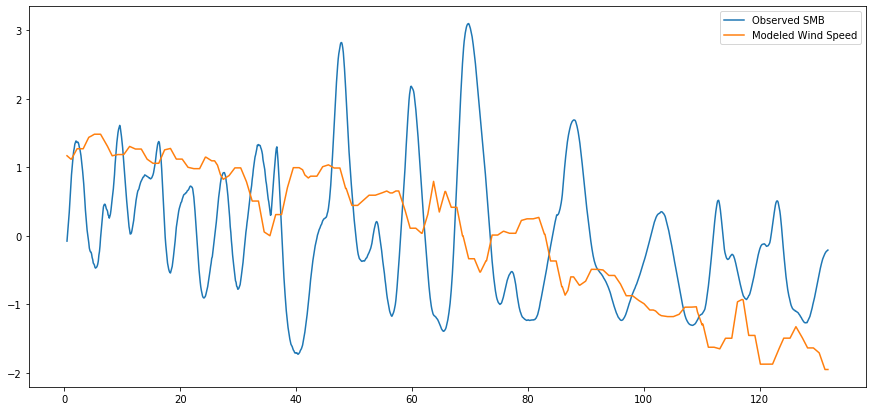

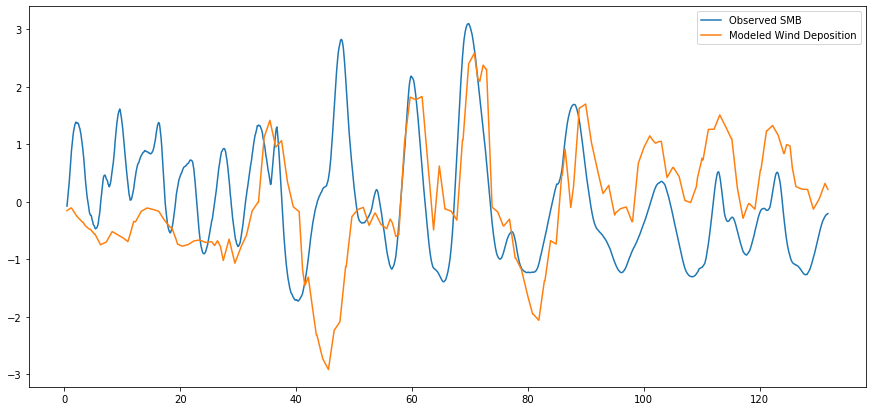

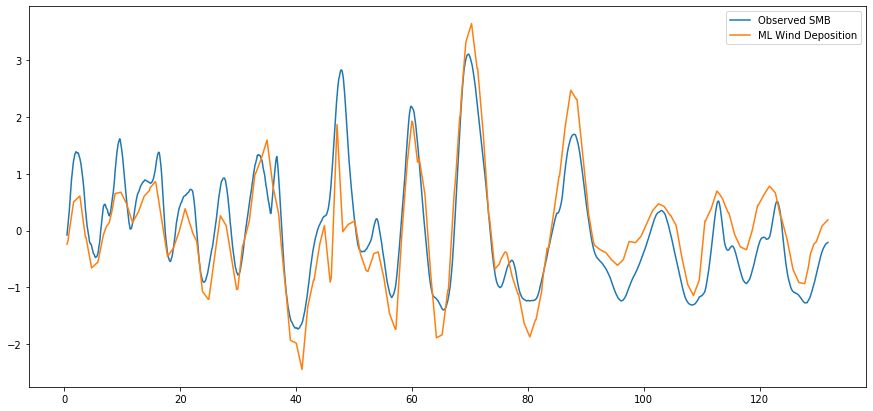

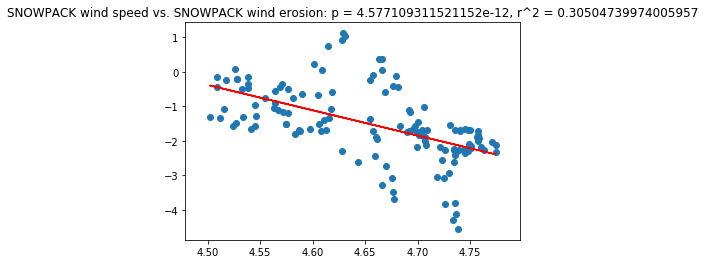

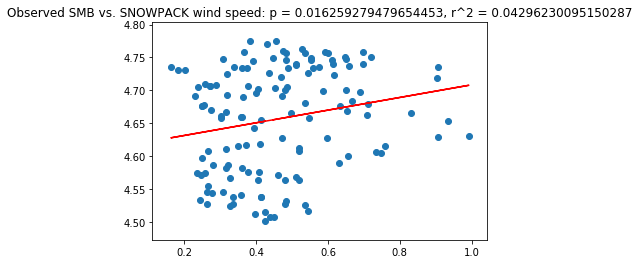

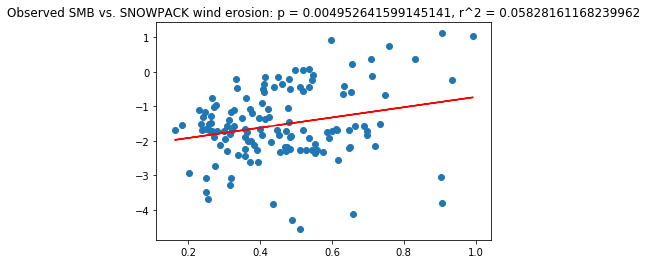

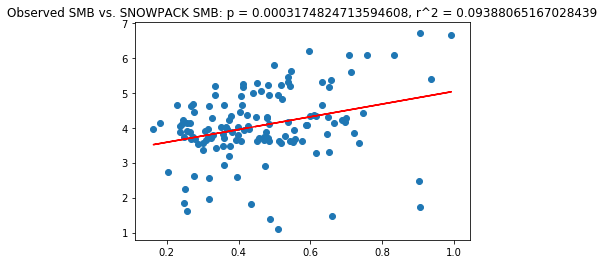

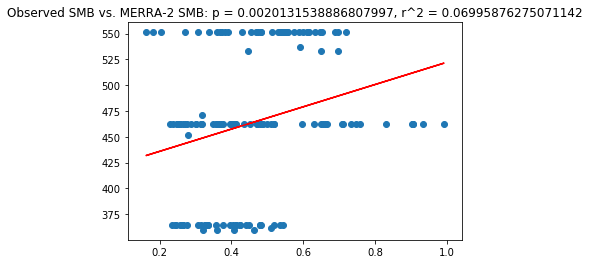

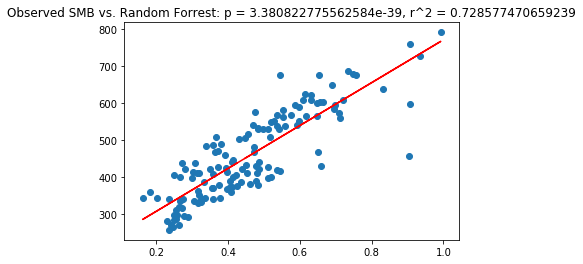

In [60]:
# Perform running average onto standard 1 km grid 
spacing = 10
obs_convulation = np.convolve(obs_accumulation[indices], np.ones(spacing)/spacing, mode='valid')
SNOWPACK_ws_convulation = np.convolve(SNOWPACK_ws[indices], np.ones(spacing)/spacing, mode='valid')
SNOWPACK_we_convulation = np.convolve(SNOWPACK_we[indices], np.ones(spacing)/spacing, mode='valid')
SNOWPACK_SMB_convulation = np.convolve(SNOWPACK_SMB[indices], np.ones(spacing)/spacing, mode='valid')
M2_SMB_convulation = np.convolve(M2_obs[indices], np.ones(spacing)/spacing, mode='valid')
RF_convulation = np.convolve(M2_RF[indices], np.ones(spacing)/spacing, mode='valid')
dat_convulation = np.convolve(dat, np.ones(spacing)/spacing, mode='valid')

std_obs = (obs_convulation - obs_convulation.mean()) / obs_convulation.std()
std_ws = (SNOWPACK_ws_convulation - SNOWPACK_ws_convulation.mean()) / SNOWPACK_ws_convulation.std()
plt.figure(figsize=(15, 7))
plt.plot(dat_convulation, std_obs, label='Observed SMB')
plt.plot(dat_convulation, std_ws, label='Modeled Wind Speed')
plt.legend()

std_we = (SNOWPACK_we_convulation - SNOWPACK_we_convulation.mean()) / SNOWPACK_we_convulation.std()
plt.figure(figsize=(15, 7))
plt.plot(dat_convulation, std_obs, label='Observed SMB')
plt.plot(dat_convulation, std_we, label='Modeled Wind Deposition')
plt.legend()

std_rf = (RF_convulation - RF_convulation.mean()) / RF_convulation.std()
plt.figure(figsize=(15, 7))
plt.plot(dat_convulation, std_obs, label='Observed SMB')
plt.plot(dat_convulation, std_rf, label='ML Wind Deposition')
plt.legend()

plt.figure()
x = SNOWPACK_ws_convulation[::spacing]
y = SNOWPACK_we_convulation[::spacing]
res = stats.linregress(x, y)
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.title("SNOWPACK wind speed vs. SNOWPACK wind erosion: p = " + str(res.pvalue) + ", r^2 = " + str(res.rvalue**2))
plt.figure()
x = obs_convulation[::spacing]
y = SNOWPACK_ws_convulation[::spacing]
res = stats.linregress(x, y)
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.title("Observed SMB vs. SNOWPACK wind speed: p = " + str(res.pvalue) + ", r^2 = " + str(res.rvalue**2))

plt.figure()
x = obs_convulation[::spacing]
y = SNOWPACK_we_convulation[::spacing]
res = stats.linregress(x, y)
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.title("Observed SMB vs. SNOWPACK wind erosion: p = " + str(res.pvalue) + ", r^2 = " + str(res.rvalue**2))

plt.figure()
x = obs_convulation[::spacing]
y = SNOWPACK_SMB_convulation[::spacing]
res = stats.linregress(x, y)
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.title("Observed SMB vs. SNOWPACK SMB: p = " + str(res.pvalue) + ", r^2 = " + str(res.rvalue**2))

plt.figure()
x = obs_convulation[::spacing]
y = M2_SMB_convulation[::spacing]
res = stats.linregress(x, y)
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.title("Observed SMB vs. MERRA-2 SMB: p = " + str(res.pvalue) + ", r^2 = " + str(res.rvalue**2))

plt.figure()
x = obs_convulation[::spacing]
y = RF_convulation[::spacing] + M2_SMB_convulation[::spacing]
res = stats.linregress(x, y)
plt.scatter(x, y)
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.title("Observed SMB vs. Random Forrest: p = " + str(res.pvalue) + ", r^2 = " + str(res.rvalue**2))

## Scatter plots

In [61]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

0.0003174824713594608
0.09388065167028442
175.6016747895616


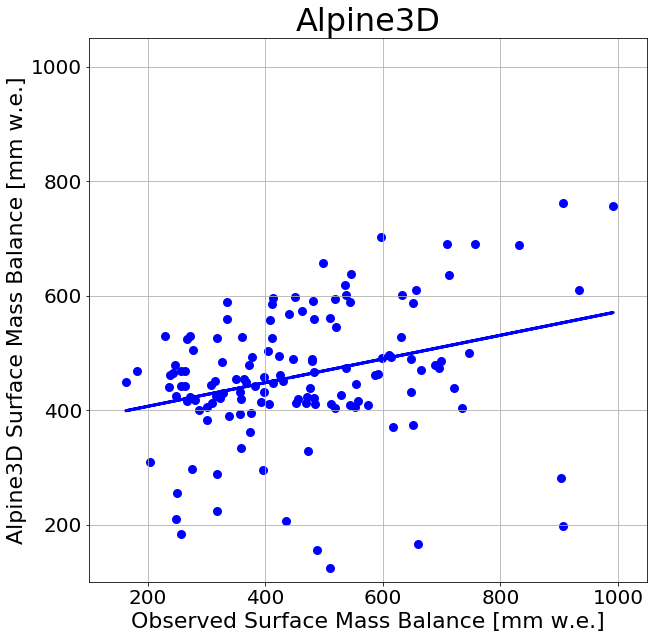

In [62]:
plt.figure(figsize=(10,10))
x = 1000 * obs_convulation[::spacing]
y = SNOWPACK_SMB_convulation[::spacing] * snowpack_factor.values
res = stats.linregress(x, y)
plt.scatter(x, y, c='b', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'b', label='fitted line', linewidth=3)
plt.xlim([100, 1050])
plt.ylim([100, 1050])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("Alpine3D", fontsize=32)
plt.ylabel("Alpine3D Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print(res.pvalue)
print(res.rvalue**2)
print(rmse(x, y))
plt.savefig('Alpine3D_Scatter.pdf', format='pdf', dpi=20)

0.0020131538886807776
0.06995876275071153
167.75843063673975


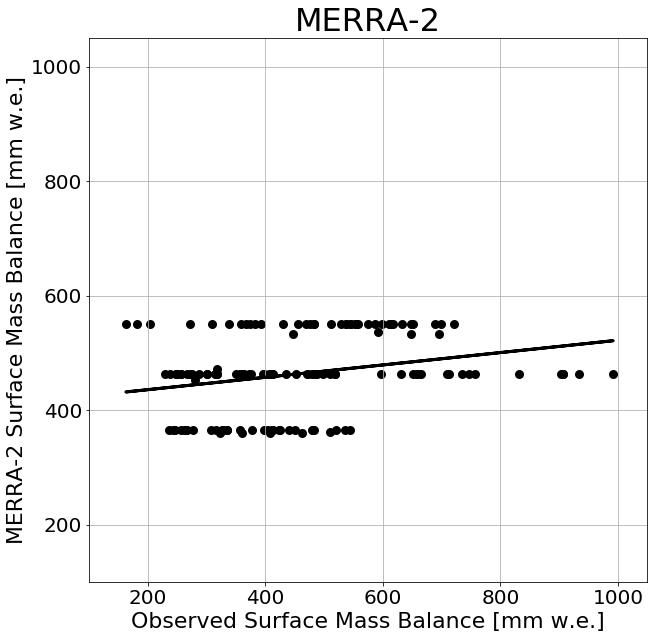

In [63]:
plt.figure(figsize=(10,10))
x = 1000 * obs_convulation[::spacing]
y = M2_SMB_convulation[::spacing]
res = stats.linregress(x, y)
plt.scatter(x, y, c='k', linewidth=3)
plt.plot(x, res.intercept + res.slope*x, 'k', label='fitted line', linewidth=3)
plt.title("Observed SMB vs. SNOWPACK SMB: p = " + str(res.pvalue) + ", r^2 = " + str(res.rvalue**2))
plt.xlim([100, 1050])
plt.ylim([100, 1050])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.title("MERRA-2", fontsize=32)
plt.ylabel("MERRA-2 Surface Mass Balance [mm w.e.]", fontsize=22)
plt.xlabel("Observed Surface Mass Balance [mm w.e.]", fontsize=22)
print(res.pvalue)
print(res.rvalue**2)
print(rmse(x, y))
plt.savefig('MERRA2_Scatter.pdf', format='pdf', dpi=20)